In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from kornia.contrib import connected_components
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
from uloss_wmh.loss_functions.neven import *

In [4]:
"""
I need to construct an example.
For that example, I need to construct an example vector map, a seed map
and two instances lets say.

I need a:

[ ] mask
[ ] example vector map
[ ] spatial dims
[ ] 
"""

'\nI need to construct an example.\nFor that example, I need to construct an example vector map, a seed map\nand two instances lets say.\n\nI need a:\n\n[ ] mask\n[ ] example vector map\n[ ] spatial dims\n[ ] \n'

In [5]:
from ulw_data.torch_dataset.challenge_data_pipeline import train_data_pipeline

In [6]:
collated_folder = "/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset/preprocessed/collated/"
train_ds, val_ds = train_data_pipeline(ds_path=collated_folder, val_proportion=0.15, seed=5, transforms=None, dims=2)

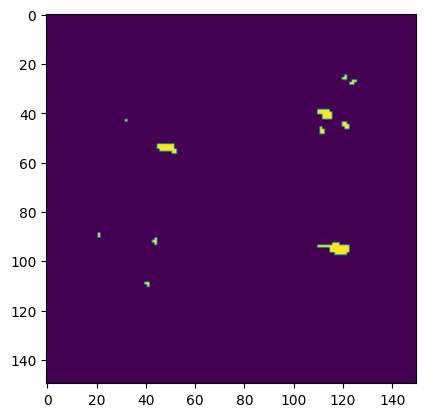

In [7]:
example_label = train_ds[67]['label'][0][25:175, 25:175]
plt.imshow(example_label)

In [8]:
import kornia

In [9]:
ccs = kornia.contrib.connected_components(example_label.unsqueeze(0).unsqueeze(0).type(torch.float32), num_iterations=350)

In [10]:
example_label_instances = ccs

In [11]:
from monai.losses import DiceLoss

In [12]:
base_loss = DiceLoss(
    sigmoid=False,
    softmax=False
)

### Testing my implementation of neven

In [13]:
torch.Tensor([1,2]).shape

torch.Size([2])

In [14]:
%autoreload

In [15]:
from uloss_wmh.loss_functions.neven import *

### Overfitting on the one image

In [16]:
neven_loss = NevenLoss(
    spatial_dims = (150,150),
    base_loss = base_loss,
    learnable_centre=True,
    instance_weight=1.,
    seed_weight=1.,
    smooth_weight=1.,
    detach_means=True,
    apply_l2p_adjustment=True,
    l2p_tanh_scale=2,
    l2p_tanh_offset=4.6
)

In [17]:
# just define a random input embedding vector
offset_vector_random = torch.randn(1, 2, 150, 150).cuda() * 0.5
log_2pres_squared_random = torch.randn(1,2,150,150).cuda() #+ -2.02 #-3.9#torch.randn(1, 2, 150, 150) * 3
seed_map_random = torch.randn(1, 1, 150, 150).cuda()

class InputsWrapper(torch.nn.Module):
    def __init__(self, offset_vector_random, log_2pres_squared_random, seed_map_random):
        super().__init__()

        self.offset_vector_random = torch.nn.Parameter(offset_vector_random)
        self.log_2pres_squared_random = torch.nn.Parameter(log_2pres_squared_random)
        # self.log_2pres_squared_random = log_2pres_squared_random
        self.seed_map_random = torch.nn.Parameter(seed_map_random)
        self.instance_distributions = None
        
    def forward(self):
        loss, instance_distributions = neven_loss(
            offset_vectors=self.offset_vector_random,
            # log_2pres_squared=(self.log_2pres_squared_random.tanh() * 2) - 4.6,
            log_2pres_squared=self.log_2pres_squared_random,
            seed_map=self.seed_map_random,
            label_instances=example_label_instances.cuda(),
        )
        self.instance_distributions = instance_distributions

        return loss

In [18]:
model = InputsWrapper(offset_vector_random, log_2pres_squared_random, seed_map_random)

In [21]:
optimizer = torch.optim.SGD(model.parameters(), lr=2)

In [22]:
for i in tqdm(range(15000)):
    loss = model()
    loss.backward()
    if i % 1500 == 0:
        print("LOSS: ", loss)
        print(model.offset_vector_random.data[0][0][60][40])
        print(model.offset_vector_random.grad[0][0][60][40])
    optimizer.step()
    optimizer.zero_grad()

  0%|                                                                                                                                                       | 7/15000 [00:00<07:47, 32.09it/s]

LOSS:  tensor(344.9404, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.4607, device='cuda:0')
tensor(-4.0839e-06, device='cuda:0')


 10%|██████████████▊                                                                                                                                     | 1507/15000 [00:41<06:08, 36.61it/s]

LOSS:  tensor(811.6173, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.4595, device='cuda:0')
tensor(-3.9049e-07, device='cuda:0')


 20%|█████████████████████████████▋                                                                                                                      | 3007/15000 [01:23<05:27, 36.61it/s]

LOSS:  tensor(783.3533, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.4583, device='cuda:0')
tensor(-4.2860e-07, device='cuda:0')


 30%|████████████████████████████████████████████▍                                                                                                       | 4507/15000 [02:05<04:38, 37.71it/s]

LOSS:  tensor(782.9343, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.4570, device='cuda:0')
tensor(-4.6234e-07, device='cuda:0')


 40%|███████████████████████████████████████████████████████████▎                                                                                        | 6007/15000 [02:46<04:06, 36.45it/s]

LOSS:  tensor(773.5401, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.4555, device='cuda:0')
tensor(-4.9621e-07, device='cuda:0')


 50%|██████████████████████████████████████████████████████████████████████████                                                                          | 7507/15000 [03:27<03:23, 36.81it/s]

LOSS:  tensor(752.3577, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.4541, device='cuda:0')
tensor(-4.7877e-07, device='cuda:0')


 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 9006/15000 [04:09<02:47, 35.80it/s]

LOSS:  tensor(752.3184, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.4526, device='cuda:0')
tensor(-4.9931e-07, device='cuda:0')


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 10506/15000 [04:50<02:05, 35.77it/s]

LOSS:  tensor(752.2914, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.4511, device='cuda:0')
tensor(-5.1690e-07, device='cuda:0')


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 12006/15000 [05:31<01:19, 37.53it/s]

LOSS:  tensor(752.2707, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.4495, device='cuda:0')
tensor(-5.3127e-07, device='cuda:0')


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 13506/15000 [06:12<00:41, 36.17it/s]

LOSS:  tensor(752.2527, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-0.4479, device='cuda:0')
tensor(-5.4277e-07, device='cuda:0')


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [06:54<00:00, 36.21it/s]


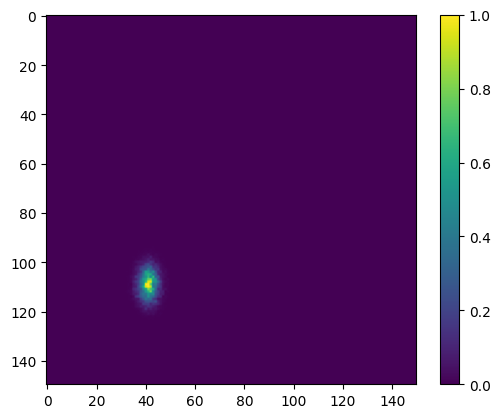

In [39]:
plt.imshow(model.instance_distributions[10].cpu());
plt.colorbar();

In [43]:
torch.stack(model.instance_distributions).cpu().max(dim=0)[0].shape

torch.Size([150, 150])

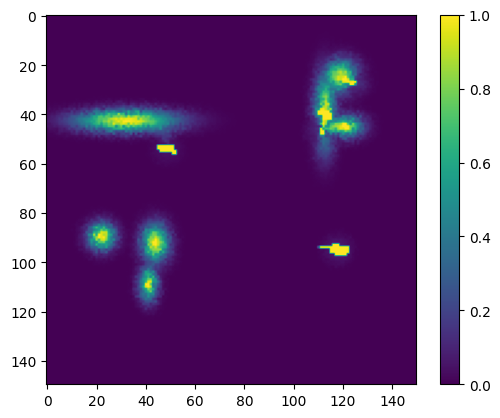

In [44]:
plt.imshow(torch.stack(model.instance_distributions).cpu().max(dim=0)[0]);
plt.colorbar();

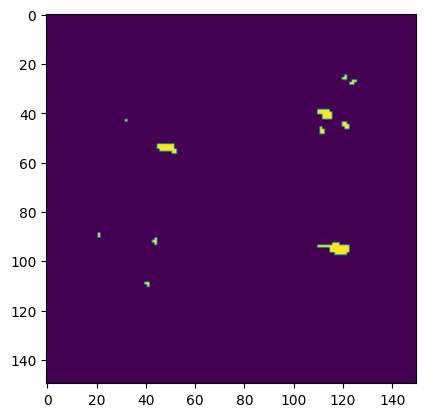

In [38]:
plt.imshow(example_label)

In [27]:
grid = torch.stack(
            torch.meshgrid(
                *[torch.arange(0, sdi, 1) for sdi in [150,150]],
                indexing='ij'
            )
        )

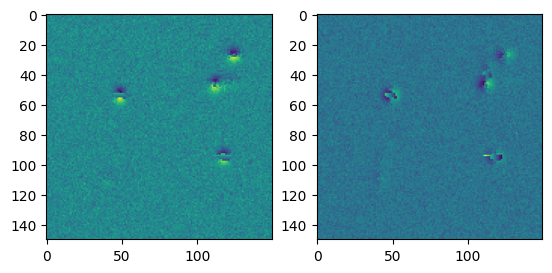

In [28]:
plt.subplot(1,2,1)
#offset_vector_random
#log_2pres_squared_random
#seed_map_random

#embedding = grid/150 + model.offset_vector_random.detach().tanh()
embedding = grid + model.offset_vector_random.detach().cpu()

# plt.imshow(embedding[0,1]); plt.colorbar()
# plt.imshow(model.log_2pres_squared_random[0,0].detach()); plt.colorbar()
# plt.imshow(model.seed_map_random[0,0].detach()); plt.colorbar()
plt.imshow(model.offset_vector_random.detach().cpu()[0,0]);# plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(model.offset_vector_random.detach().cpu()[0,1]);# plt.colorbar()

In [49]:
grid.shape

torch.Size([2, 150, 150])

In [50]:
dist = (-(embedding[0] - torch.Tensor([25,85]).reshape((2,1,1))).pow(2.)/(2 * (5 ** 2))).sum(dim=0).exp()

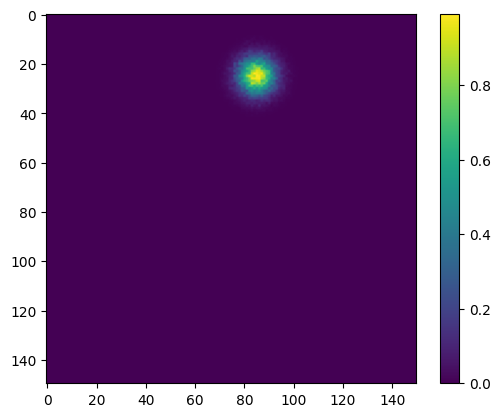

In [51]:
plt.imshow(dist); plt.colorbar()

In [52]:
points_random = embedding.reshape((2, -1))

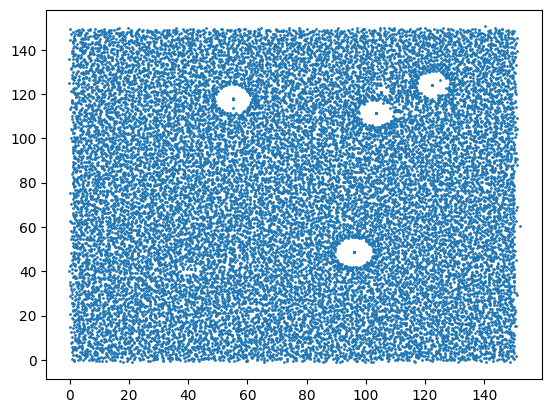

In [53]:
plt.scatter(150-points_random[0], points_random[1], s=1)

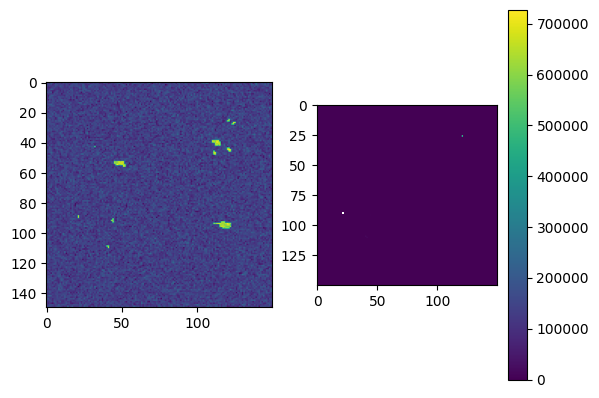

In [48]:
plt.subplot(1,2,1)
#offset_vector_random
#log_2pres_squared_random
#seed_map_random

sigma_random = (1./(2*model.log_2pres_squared_random.exp())).sqrt()
plt.imshow(model.seed_map_random[0,0].detach().cpu())#; plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(sigma_random[0,0].detach().cpu()); plt.colorbar()

In [425]:
sigma_random[0,0,20]

tensor([0.4933, 0.6225, 0.3904, 0.3171, 1.5289, 0.3404, 0.6878, 0.3891, 0.6825,
        0.3979, 0.6603, 0.4198, 0.5545, 0.2808, 1.1185, 1.1562, 0.5918, 0.5147,
        0.3715, 1.0408, 0.7825, 1.2349, 0.4548, 0.8440, 0.5333, 0.5852, 0.7714,
        0.3632, 0.6069, 1.0095, 1.2187, 0.4575, 0.8774, 1.1053, 0.7362, 0.3202,
        0.8498, 1.0570, 1.1875, 0.5477, 0.5506, 2.9017, 0.3329, 0.6715, 1.7925,
        0.8632, 0.3657, 0.2612, 0.5520, 0.3831, 0.6895, 0.5252, 1.0347, 0.6801,
        2.1028, 0.4432, 0.3421, 0.5141, 0.2753, 0.8059, 0.3811, 0.4438, 0.2685,
        0.8256, 0.3737, 1.1987, 0.6410, 0.6424, 1.0222, 0.2857, 1.2017, 1.1901,
        1.0649, 1.1102, 0.7509, 0.5681, 0.6566, 2.5809, 0.4101, 0.4101, 0.4101,
        0.4101, 0.4101, 0.4101, 0.4101, 0.4101, 0.4101, 0.4101, 0.4101, 0.4101,
        0.4101, 0.4101, 0.8425, 0.2972, 0.7053, 0.2666, 0.2365, 0.4882, 0.9495,
        0.7527], device='cuda:0', grad_fn=<SelectBackward0>)

### list of what is working or needs checking

- [x] trains with fixed centre and full scale vectors
- [x] trains with learned centre and full scale vectors (yes works even better)
- [ ] scaling down the vectors, does it still train?
- [ ] finding a suitable way to constrain log2pres does it train?